# Structured Output

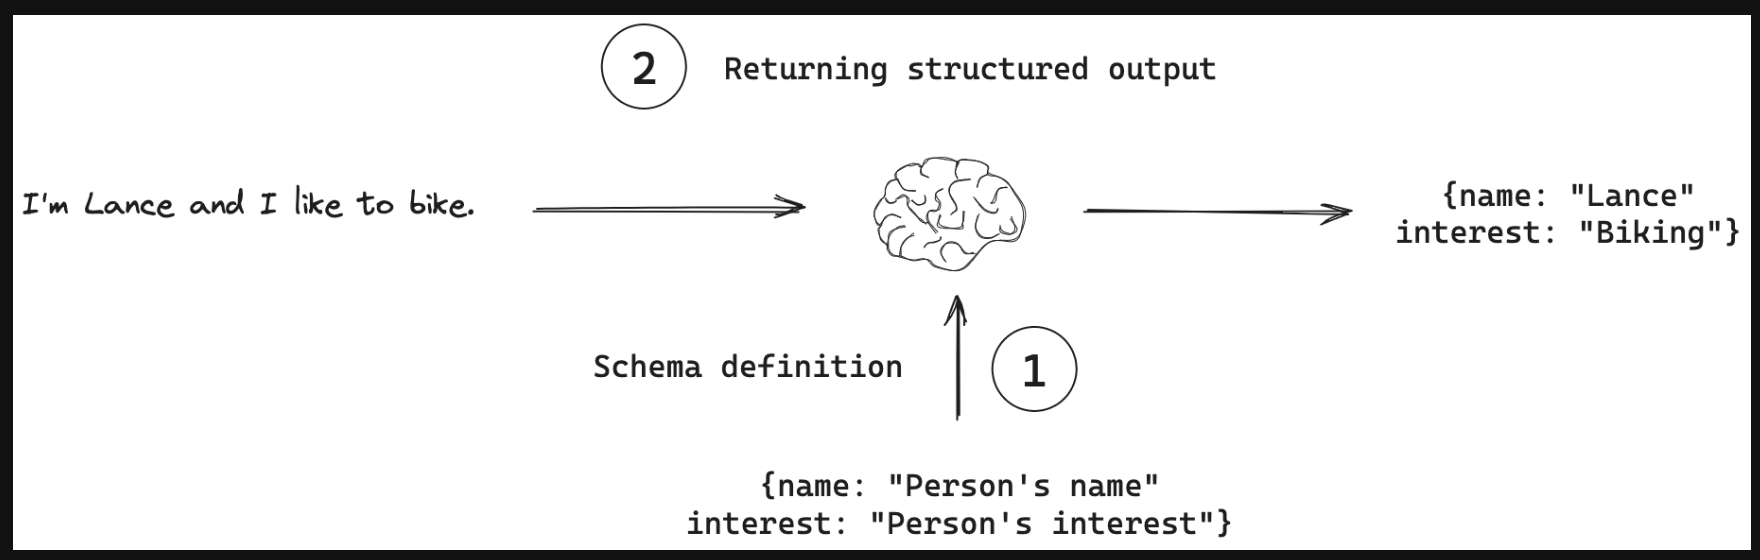

> 입력되는 자연어에 대해, 사전에 정의한 출력 schema의 형식대로 llm이 답변을 채워 반환하도록 하는 것

- schema 정의 시 함께 정의하는 description이 prompt에 추가되어 원하는 형태로 답변을 받을 수 있도록 보장함

## 환경 변수

In [2]:
import os
from dotenv import load_dotenv

env_file_path = os.path.join("..", "config", ".env")
load_dotenv(env_file_path)

True

## 원하는 출력 형태 지정하기 (`with_structured_output()`)

In [ ]:
from pydantic import BaseModel, Field # Field : 해당 출력 필드의 description 지정을 위한 함수
from langchain_openai import ChatOpenAI

# define response schema model
class MovieResponseSchema(BaseModel):
    title : str = Field(description="영화 제목")
    director: str = Field(description="감독 이름")
    genre: str = Field(description="영화 장르")
    release_year: int = Field(description="개봉 연도")

# define model
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0
)
llm_with_structured_output = llm.with_structured_output(MovieResponseSchema)

In [4]:
llm_with_structured_output.invoke("타이타닉 영화에 대해 설명해주세요.")

MovieResponseSchema(title='타이타닉', director='제임스 카메론', genre='로맨스, 드라마', release_year=1997)

## 여러 개의 Response Schema 지정하기

In [5]:
# typing.Union : 여러 타입이 허용될 때 사용
# Union[BaseModel, BaseModel, ...]
from typing import Union
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

# define response schemas
class MovieResponseSchema(BaseModel):
    title: str = Field(description="영화 제목")
    director: str = Field(description="감독 이름")
    genre: str = Field(description="영화 장르")
    release_year: str = Field(description="개봉 연도")

class ConversationResponseSchema(BaseModel):
    response: str = Field(description="사용자 질문에 대한 답변")

class UnionResponseSchema(BaseModel):
    response: Union[MovieResponseSchema, ConversationResponseSchema]

# define model
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0
)
llm_with_structured_output = llm.with_structured_output(UnionResponseSchema)

In [6]:
# movie query
llm_with_structured_output.invoke("타이타닉 영화에 대해 설명해주세요")

UnionResponseSchema(response=MovieResponseSchema(title='타이타닉', director='제임스 카메론', genre='로맨스, 드라마', release_year='1997'))

In [7]:
# conversation query
llm_with_structured_output.invoke("안녕하세요! 오늘 기분이 어떠신가요?")

UnionResponseSchema(response=ConversationResponseSchema(response='안녕하세요! 오늘 기분은 아주 좋습니다. 당신은 어떠신가요? 하루가 잘 시작되었기를 바랍니다.'))

## 지정된 출력 형태를 가진 Agent

### Step 1. 출력 schema 정의하기

In [8]:
from pydantic import BaseModel, Field

class MovieResponseSchema(BaseModel):
    title: str = Field(description="영화 제목")
    director: str = Field(description="영화 감독")
    genre: str = Field(description="영화 장르")
    release_year: int = Field(description="개봉 연도")

### Step 2. 도구 정의하기

In [9]:
from langchain_core.tools import tool
from typing import Literal

@tool
def get_movie_info(movie: Literal["타이타닉", "노팅힐"]) -> str:
    """
    영화의 정보를 수집하기 위해 이 도구를 사용하세요

    args:
        - movie(str) = 영화 제목 ("타이타닉" 또는 "노팅힐"의 값을 가짐)
    return:
        - movie_info(str) = 영화에 대한 정보가 담긴 문자열
    """
    if movie == "타이타닉":
        return "영화 타이타닉은 1997년 개봉하였고, 감독은 제임스 카메론입니다. 장르는 로맨스/드라마입니다."
    elif movie == "노팅힐":
        return "영화 노팅힐은 1999년 개봉하였고, 감독은 로저 미첼입니다. 장르는 로맨틱 코미디입니다."
    else:
        raise ValueError("Unikown Movie Name!")

### Step 3. Model 정의하기

In [10]:
llm_with_tools = llm.bind_tools([get_movie_info])
llm_with_structured_output = llm.with_structured_output(MovieResponseSchema)

### Step 4. State, Node, Routing Func 정의하기

In [ ]:
from langgraph.graph import MessagesState # "messages" 키를 관리하는 사전 구축된 state
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import ToolNode


# define state
class State(MessagesState): # MessagesState를 상속받아 내부에서 messages를 관리하도록 설정 가능
    response: MovieResponseSchema # 답변 형태를 지정

# define node
def fetch_movie_info_agent(state: State):
    return {"messages" : llm_with_tools.invoke(state["messages"])}

def response_movie_info_agent(state: State):
    return {
        "response" : llm_with_structured_output.invoke([
            HumanMessage(
                content=state["messages"][-2].content
            )
        ])
    }

tool_node = ToolNode([get_movie_info])

# define routing func
def should_continue(state: State):
    if messages := state.get("messages", []): ai_message = messages[-1]
    else : raise ValueError("No AIMessage in Current State")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "continue"
    else:
        return "respond"

### Step 5. Define Graph

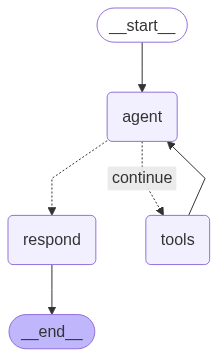

In [14]:
from langgraph.graph import StateGraph, START, END

# define graph builder
workflow = StateGraph(State)

# add nodes
workflow.add_node("agent", fetch_movie_info_agent)
workflow.add_node("respond", response_movie_info_agent)
workflow.add_node("tools", tool_node)

# add edges
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue" : "tools",
        "respond" : "respond"
    }
)
workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)

# compile graph
app = workflow.compile()

app

### 실행하기

In [16]:
response = app.invoke({"messages" : [HumanMessage(content="타이타닉 영화에 대해 설명해주세요.")]})

print(response["response"])

title='타이타닉' director='제임스 카메론' genre='로맨스/드라마' release_year=1997


## 논문 정보를 반환하는 structured output agent

### [ArViv Tool](https://python.langchain.com/docs/integrations/tools/arxiv/)

```
pip install arxiv
```

In [18]:
from langchain_community.utilities import ArxivAPIWrapper

arxiv_client = ArxivAPIWrapper()

In [20]:
info = arxiv_client.run("1605.08386")

print(info)

Published: 2016-05-26
Title: Heat-bath random walks with Markov bases
Authors: Caprice Stanley, Tobias Windisch
Summary: Graphs on lattice points are studied whose edges come from a finite set of
allowed moves of arbitrary length. We show that the diameter of these graphs on
fibers of a fixed integer matrix can be bounded from above by a constant. We
then study the mixing behaviour of heat-bath random walks on these graphs. We
also state explicit conditions on the set of moves so that the heat-bath random
walk, a generalization of the Glauber dynamics, is an expander in fixed
dimension.


In [21]:
info = arxiv_client.run("2312.15166")

print(info)

Published: 2024-04-04
Title: SOLAR 10.7B: Scaling Large Language Models with Simple yet Effective Depth Up-Scaling
Authors: Dahyun Kim, Chanjun Park, Sanghoon Kim, Wonsung Lee, Wonho Song, Yunsu Kim, Hyeonwoo Kim, Yungi Kim, Hyeonju Lee, Jihoo Kim, Changbae Ahn, Seonghoon Yang, Sukyung Lee, Hyunbyung Park, Gyoungjin Gim, Mikyoung Cha, Hwalsuk Lee, Sunghun Kim
Summary: We introduce SOLAR 10.7B, a large language model (LLM) with 10.7 billion
parameters, demonstrating superior performance in various natural language
processing (NLP) tasks. Inspired by recent efforts to efficiently up-scale
LLMs, we present a method for scaling LLMs called depth up-scaling (DUS), which
encompasses depthwise scaling and continued pretraining. In contrast to other
LLM up-scaling methods that use mixture-of-experts, DUS does not require
complex changes to train and inference efficiently. We show experimentally that
DUS is simple yet effective in scaling up high-performance LLMs from small
ones. Building on th

In [24]:
info = arxiv_client.run("2312.15166www")

print(info)

No good Arxiv Result was found


In [22]:
type(info)

str

## 논문 정보 반환하는 Agent 만들기

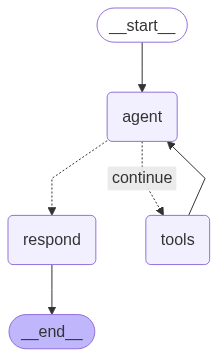

In [51]:
from pydantic import BaseModel, Field
from langchain_core.tools import tool
from langchain_community.utilities import ArxivAPIWrapper
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import ToolNode

# define response schema
class PaperResponseSchema(BaseModel):
    pubulished: str = Field(description="논문 출판 일자")
    title: str = Field(description="논문 제목")
    authors: list[str] = Field(description="논문의 저자")
    summary : str = Field(description="논문 내용 요약본")

# define tool
arxiv_client = ArxivAPIWrapper()
@tool
def get_paper_info(paper_code:str):
    """
    논문의 정보를 수집하기 위해 이 도구를 사용하세요.

    args:
        - paper_code (str) : 논문의 arxiv 코드
    
    return:
        - paper_inof (str) : 논문의 정보가 포함된 문자열
    """
    
    return arxiv_client.run(paper_code)

# define models
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0
)
llm_with_tools = llm.bind_tools([get_paper_info])
llm_with_structured_output = llm.with_structured_output(PaperResponseSchema)

# define State
class State(MessagesState):
    response: PaperResponseSchema

# define nodes
def get_paper_info_agent(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages" : [response]}

def response_paper_info_agent(state: State):
    return {
        "response" : llm_with_structured_output.invoke([
            HumanMessage(
                content=state["messages"][-2].content
            )
        ])
    }

tool_node = ToolNode([get_paper_info])

# define routing func
def should_continue(state: State):
    if messages := state.get("messages", []) : ai_message = messages[-1]
    else : raise ValueError("No AI Message Found in Current State")

    if hasattr(ai_message, "tool_calls") and (len(ai_message.tool_calls) > 0):
        return "continue"
    else:
        return "respond"

# define graph builder
workflow = StateGraph(State)

# add nodes
workflow.add_node("agent", get_paper_info_agent)
workflow.add_node("respond", response_paper_info_agent)
workflow.add_node("tools", tool_node)

# add edges
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue" : "tools",
        "respond" : "respond"
    }
)
workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)

# compile graph
app = workflow.compile()

app

In [54]:
response = app.invoke({
    "messages" : [HumanMessage(content="2312.15166 논문에 대한 정보를 알려주세요.")]
})

print(response["response"])

pubulished='2024-04-04' title='SOLAR 10.7B: Scaling Large Language Models with Simple yet Effective Depth Up-Scaling' authors=['Dahyun Kim', 'Chanjun Park', 'Sanghoon Kim', 'Wonsung Lee', 'Wonho Song', 'Yunsu Kim', 'Hyeonwoo Kim', 'Yungi Kim', 'Hyeonju Lee', 'Jihoo Kim', 'Changbae Ahn', 'Seonghoon Yang', 'Sukyung Lee', 'Hyunbyung Park', 'Gyoungjin Gim', 'Mikyoung Cha', 'Hwalsuk Lee', 'Sunghun Kim'] summary='In this paper, we introduce SOLAR 10.7B, a large language model (LLM) with 10.7 billion parameters, which demonstrates superior performance across a range of natural language processing (NLP) tasks. Our work is inspired by recent efforts to efficiently scale up LLMs, and we propose a novel method called depth up-scaling (DUS). This method involves depthwise scaling and continued pretraining, offering a simpler alternative to other up-scaling methods that rely on complex mixture-of-experts techniques. \n\nOur experimental results show that DUS is both simple and effective for scaling

In [55]:
print(response["response"].summary)

In this paper, we introduce SOLAR 10.7B, a large language model (LLM) with 10.7 billion parameters, which demonstrates superior performance across a range of natural language processing (NLP) tasks. Our work is inspired by recent efforts to efficiently scale up LLMs, and we propose a novel method called depth up-scaling (DUS). This method involves depthwise scaling and continued pretraining, offering a simpler alternative to other up-scaling methods that rely on complex mixture-of-experts techniques. 

Our experimental results show that DUS is both simple and effective for scaling high-performance LLMs from smaller models. Additionally, we introduce SOLAR 10.7B-Instruct, a variant of the model fine-tuned for instruction-following tasks, which outperforms the Mixtral-8x7B-Instruct model. 

SOLAR 10.7B is made publicly available under the Apache 2.0 license, encouraging widespread access and application in the field of LLMs. This work contributes to the ongoing development of scalable an